In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:
from flax import nnx
import jax
from jax._src.tree_util import tree_structure
import jax.numpy as jnp
from jaxtyping import Array

In [3]:
from architectures.node import NeuralODE
from architectures.architectures import MLP,ResNet
from geometry.G_matrix import G_matrix
from functionals.functions import create_potentials
from functionals.linear_funcitonal_class import LinearPotential
from flows.gradient_flow import run_gradient_flow
from flows.visualization import visualize_gradient_flow_results

In [4]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

In [5]:
# Create potentials
potentials = create_potentials()

In [6]:
class parametric_model(nnx.Module):
    def __init__(self,model: nnx.Module):
        
        self.model = model
    
    def __call__(self, samples,params):

        graphdef,_ = nnx.split(self.model)
        model = nnx.merge(graphdef,params)

        return model(samples)
        

In [11]:
# Gradient flow parameters
h = 1e-2 # Time step size
max_iterations = 100
tolerance = 1e-6
n_samples = 4_000  # Monte Carlo sample size


key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)

################### Create NODE model
# If the node is time dependent do d +1 for din
model = MLP(din=3, num_layers=1, width_layers=16, dout=2, 
                         activation_fn="tanh", rngs=rngs)
gradient_flow_model = NeuralODE(
    dynamics_model=model,
    time_dependent=True,
    dt0=0.1,
)
#################### ResNet model
# model = ResNet(din=2,num_layers=2,width_layers=32,dout=2,activation_fn='tanh',rngs=rngs)
# gradient_flow_model = parametric_model(model=model)

# Set parameters to be very small (near zero)
_, initial_params = nnx.split(gradient_flow_model)
scale_factor = 1e-2  # Small scaling to keep near identity

# Scale all parameters to be small
small_params = jax.tree.map(lambda p: p * scale_factor, initial_params)

# Merge back into the node
graphdef, _ = nnx.split(gradient_flow_model)
gradient_flow_model = nnx.merge(graphdef, small_params)

# Generate reference samples from λ = N(0, I)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

G_mat_flow = G_matrix(gradient_flow_model)
# Options: quadratic, double_well, strong_double_well,quartic,four_well,strong_four_well
potential = potentials['strong_four_well'] 
solver= 'minres'


Starting gradient flow with LinearPotential...
Potential function: four_well_potential_fn
Potential parameters: {'alpha': 5.0}
Selected device: cuda:0
Initial energy: 30.547886
Iter   0: Energy = 30.002075, Grad norm: 7.23e+00


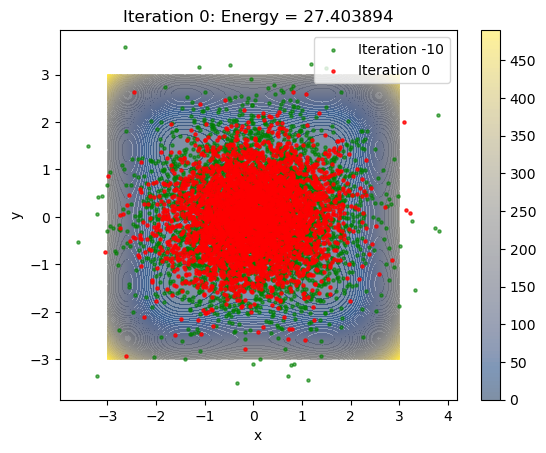

Iter  10: Energy = 26.550486, Grad norm: 1.85e+00


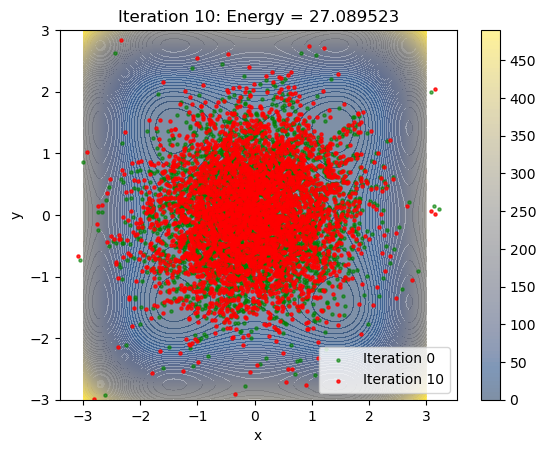

Iter  20: Energy = 26.961626, Grad norm: 1.22e+00


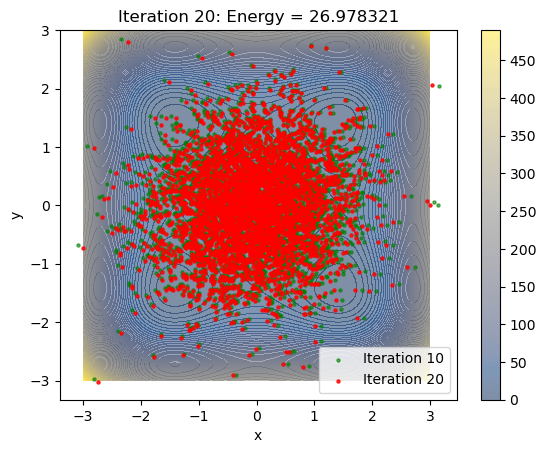

Iter  30: Energy = 26.761339, Grad norm: 1.89e+00


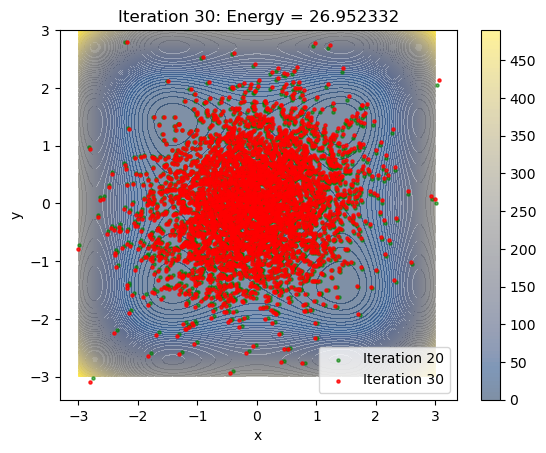

Iter  40: Energy = 26.677515, Grad norm: 9.92e-01


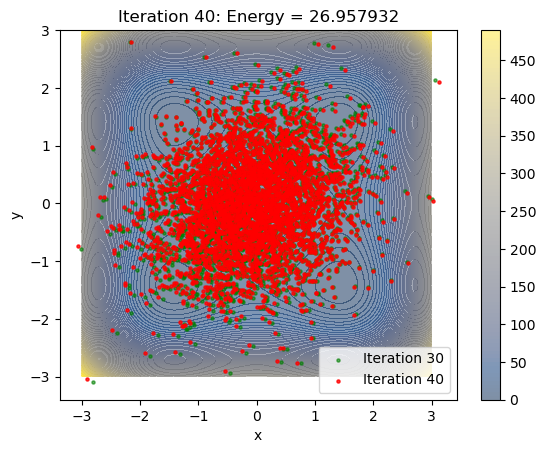

Iter  50: Energy = 26.310110, Grad norm: 1.06e+00


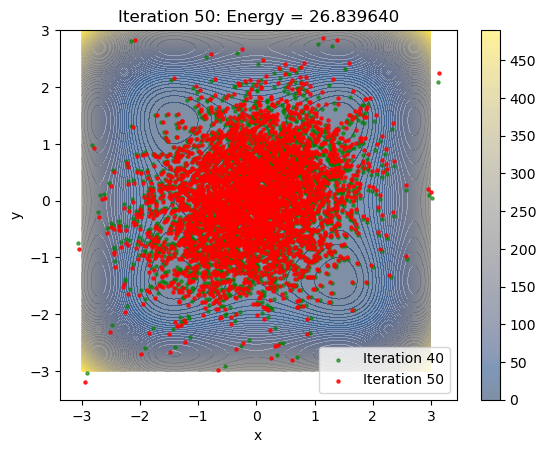

Iter  60: Energy = 25.291361, Grad norm: 3.88e+00


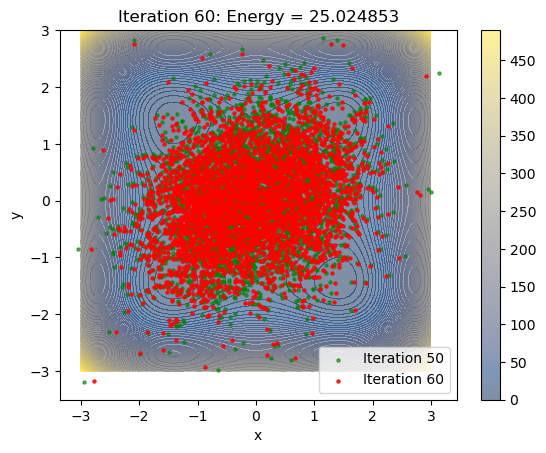

Iter  70: Energy = 20.837055, Grad norm: 5.18e+00


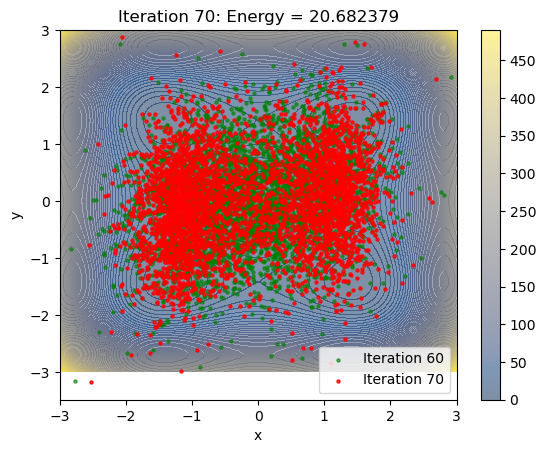

Iter  80: Energy = 17.062212, Grad norm: 4.99e+00


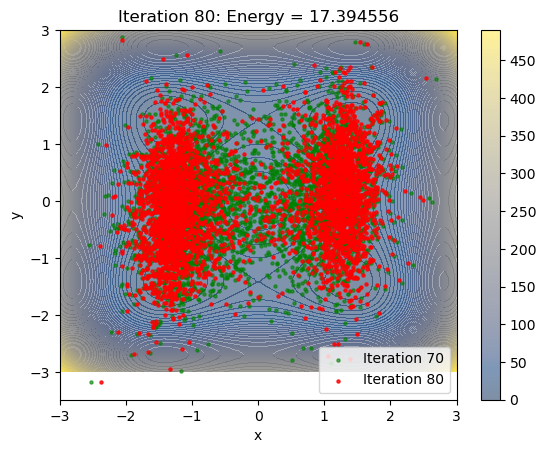

Iter  90: Energy = 16.126936, Grad norm: 2.80e+00


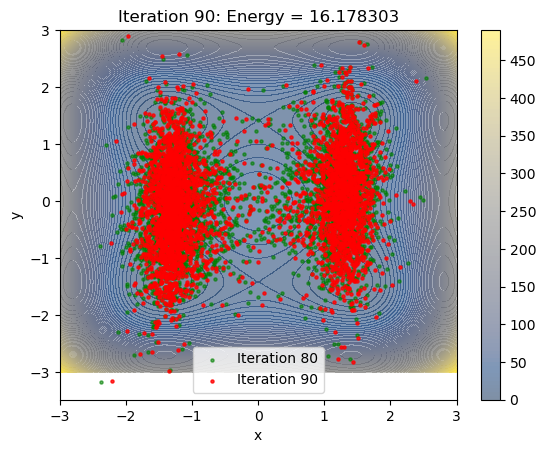

Iter  98: Energy = 15.590837, Grad norm: 2.55e+00


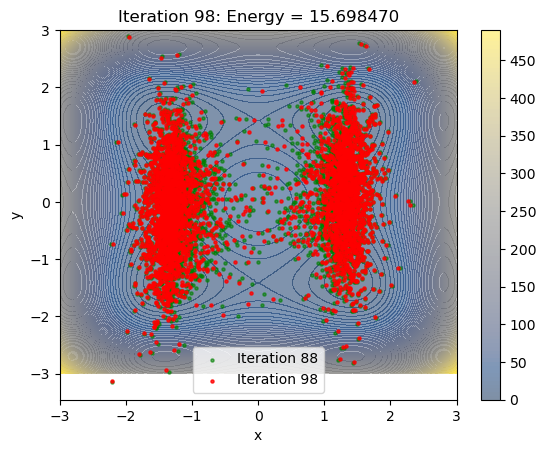


=== Integration Complete ===
Total iterations:    99
Initial energy:      30.547886
Final energy:        15.590837
Total decrease:      14.957049
Reduction ratio:     0.5104
Final param norm:    4.119804


In [12]:

results = run_gradient_flow(
    gradient_flow_model, z_samples, G_mat_flow,
    potential,solver=solver,
    h=h, max_iterations=max_iterations, tolerance=tolerance,
    progress_every=10
)

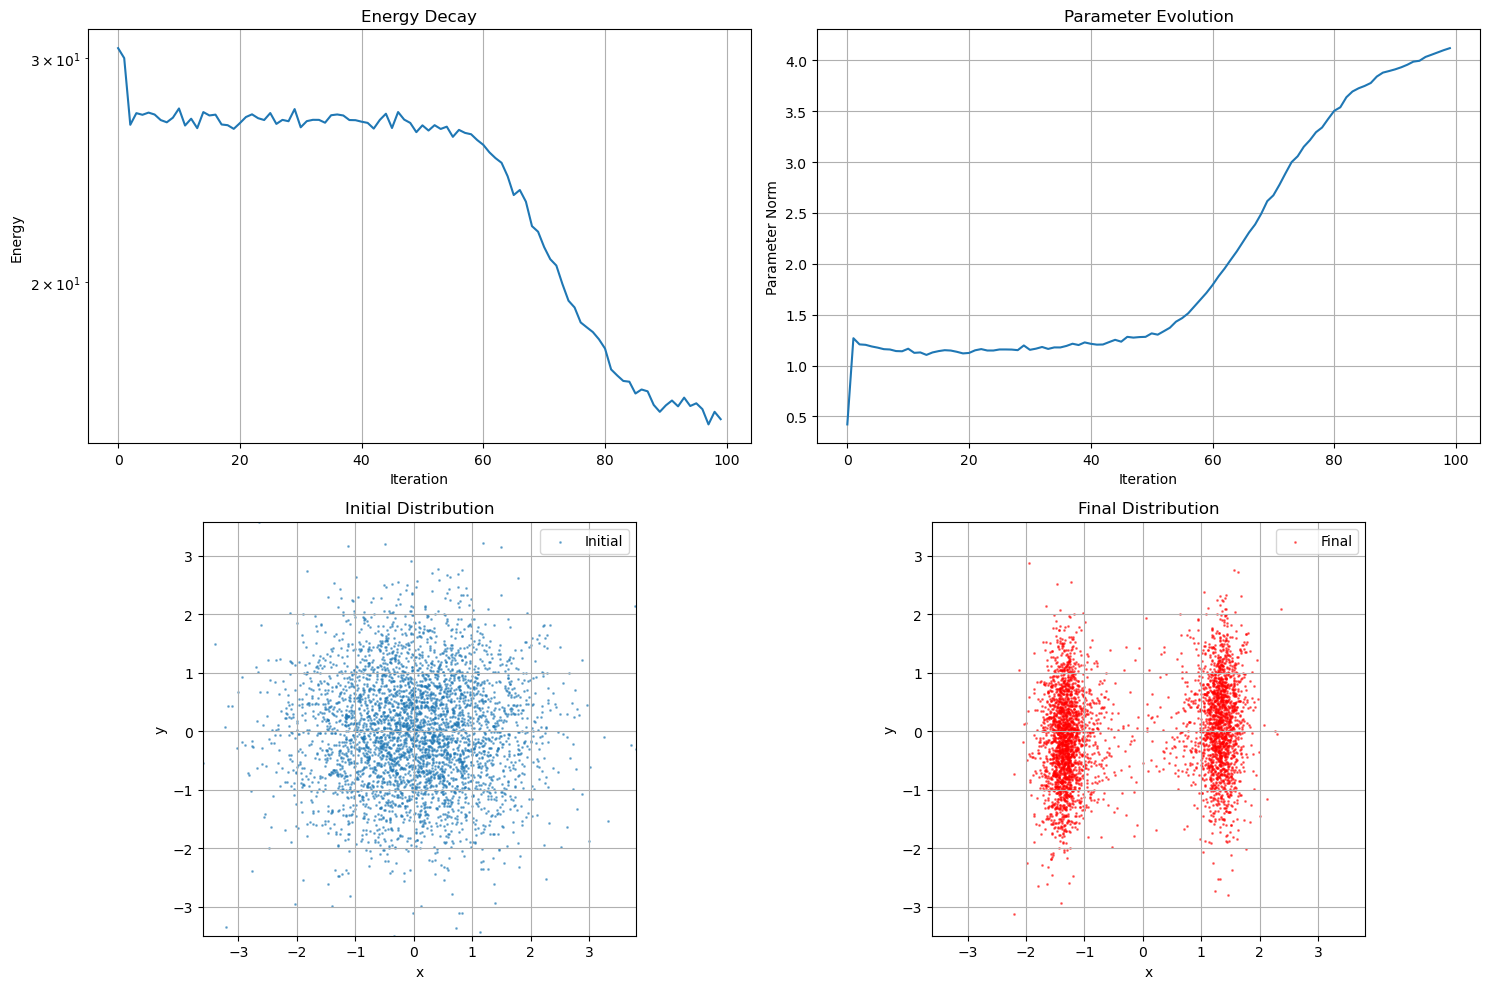

In [13]:
# Visualize results
visualize_gradient_flow_results(results)